In [1]:
using Pkg
Pkg.activate("../..")

  Activating project at `~/Documents/repos/nanoOpt.jl`


In [2]:
using Measures,LinearAlgebra,LazyGrids,LaTeXStrings,QuadGK,Plots; pyplot()

Plots.PyPlotBackend()

In [3]:
include("../../src/NanoOpt.jl")

KsspSlab (generic function with 1 method)

In [4]:
mat1 = material((1.)^2,1.0)
matSc = material(epstable("gold"),1.0)
matScDr = material(epsdrude("Au"),1.0)
#matSc = material(-11.74+1.26*im,1.0)
mat2 = material((4.1+0.051787*im)^2,1.0);

In [5]:
(0.0657+im*4)^2

-15.99568351 + 0.5256im

In [6]:
λ = 532
k₀ = 2π/λ
d = 10;

In [7]:
layer = layerstructure([mat1,matSc,mat2],[0.0,d],"up");

In [8]:
kdS1 = KsspSlab(k₀,mat1,matSc)
kdS2 = KsspSlab(k₀,mat2,matSc);

In [9]:
layer.mat[1].ε(k₀)

1.0

In [10]:
N = 100
ns = collect(LinRange(0.01,0.015,N))
ins = collect(LinRange(0.0e-2,0.002,N));

In [11]:
nsM,insM = ndgrid(ns,ins)
nsA,insA = nsM[:],insM[:];

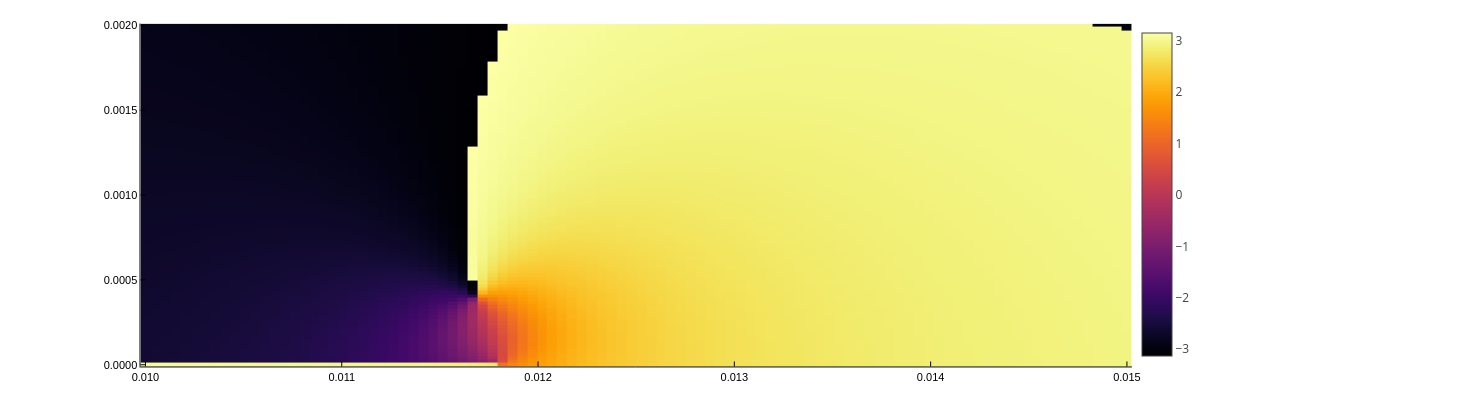

In [12]:
βT = (nsA+im*insA)

felA = [funSolv(β,k₀,layer) for β ∈ βT];

A = reshape(felA,size(nsM))

plotly()
heatmap(ns,ins,angle.(A)')

In [13]:
βRec = [ns[1], ns[end]]
βImc = [ins[1], ins[end]]

2-element Vector{Float64}:
 0.0
 0.002

In [14]:
βc = getβc(βRec,βImc,N,k₀,layer)

0.011792929292929293 + 1.0101010101010101e-5im

In [15]:
βS = NRSolver(βc,k₀,layer,1e-12)

0.011682507072259457 + 0.00039736168995117583im

In [16]:
funSolv(βS,k₀,layer)

-8.43769498715119e-15 - 4.929390229335695e-14im

In [17]:
nss = βS/k₀

0.9891628940722551 + 0.0336447850443739im

In [18]:
λspp = λ/real(nss)

537.8285044739448

In [19]:
lₛₚₚ = 1/(2k₀*imag(nss))

1258.2994602761917

# =============================================================================+

In [20]:
function calcFDistr(x::Number,k₀::Number,βS::Number,layer::layerstructure)
    ε₂ = layer.mat[2].ε(k₀)
    ε₁ = layer.mat[1].ε(k₀)
    
    ky1p = kyi(βS,layer.mat[1].k(k₀))
    ky2p = kyi(βS,layer.mat[2].k(k₀))
    ky3p = kyi(βS,layer.mat[3].k(k₀))
    
    d = layer.z[end]
    
    B = 0.5*(1-((ε₂*ky1p)/(ε₁*ky2p))); C = 0.5*(1+((ε₂*ky1p)/(ε₁*ky2p)))
    D = B*exp(im*ky2p*d)+C*exp(-im*ky2p*d)
    if x ≥ 0.
        valH = exp(im*ky1p*x)
    elseif x < 0. && x ≥ -d
        valH = B*exp(-im*ky2p*x)+C*exp(im*ky2p*x)
    else
        valH = D*exp(-im*ky3p*(x+d))
    end
end

calcFDistr (generic function with 1 method)

In [21]:
typeof(layer)

layerstructure

In [22]:
layer.z[end]

10.0

In [23]:
xt = -300.:0.1:300.

Hf = [calcFDistr(x,k₀,βS,layer) for x in xt];

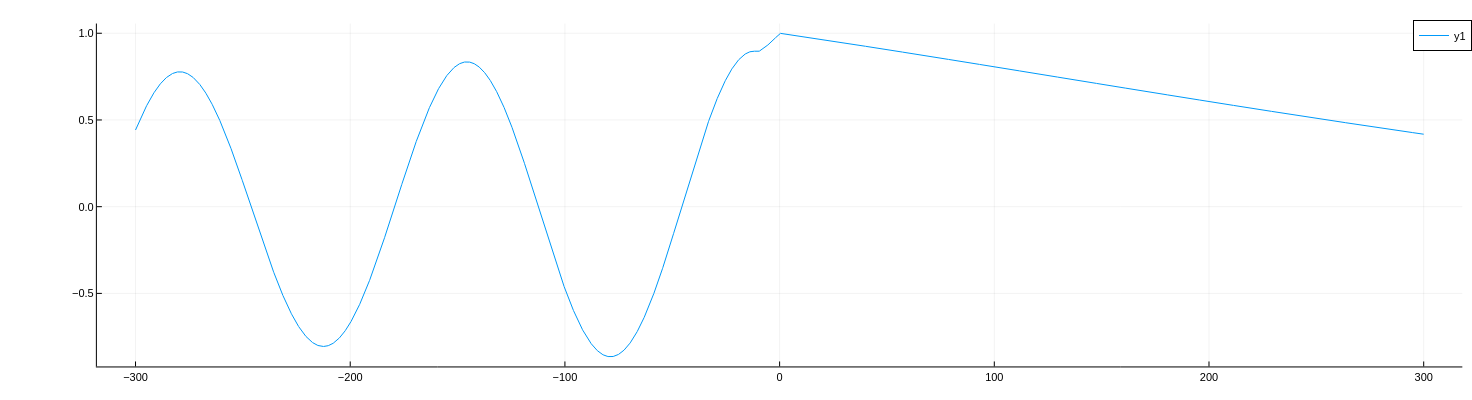

In [24]:
plot(xt,real.(Hf))

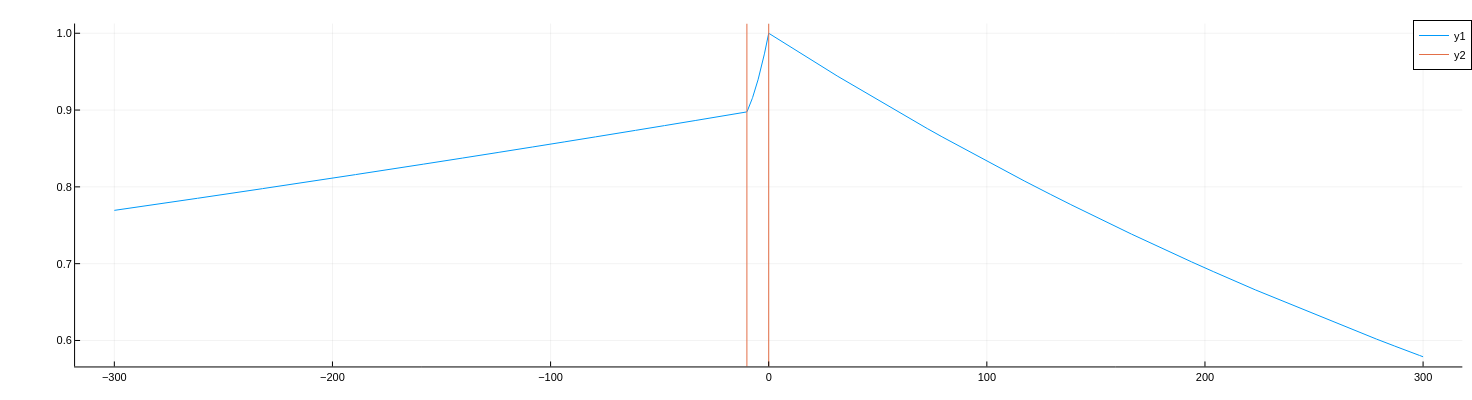

In [25]:
plot(xt,abs.(Hf))
vline!([0,-d])

# Transfer

In [26]:
function propagate(layer::layerstructure,k0::Number,βS::Number,ind::Int64,Δz::Number)
    ky = kyi(βS,layer.mat[ind].k(k0))
    if ind !=1
        d = layer.z[ind-1]
    else
        d = 0
    end
    [exp(im*ky*(Δz)) 0; 0 exp(-im*ky*(Δz))]
end

function Mmatr(layer::layerstructure,k0::Number,βS::Number,ind::Int64)
    
    layInd  = layerstructure([layer.mat[ind-1],layer.mat[ind]],[0.0,],"up")
    
    rtCu = rtcoeffs(layInd,k0,[βS,],"up") 
    Relu = rtCu.r.TM[1]
    Telu = rtCu.t.TM[1]
    
    rtCd = rtcoeffs(layInd,k0,[βS,],"down") 
    Reld = rtCd.r.TM[1]
    Teld = rtCd.t.TM[1]
    
   (1/Teld)*[Telu*Teld-Relu*Reld Reld; -Relu 1]
    
    #(1/Telu)*[1 Relu; Relu 1]
end

function getind(layer::layerstructure,z::Number)
    zArr = layer.z
    maxEl = length(layer.mat)
    
    flag = true
    ind = 1
    while flag
        if ind == 1
            if z ≤ zArr[ind]
                flag = false
            else
                ind += 1
            end
        elseif ind == maxEl
            flag = false
        else
            if z ≤ zArr[ind] && z > zArr[ind-1]
                flag = false
            else
                ind +=1
            end
        end
    end
    
    ind
end

function transefM(layer::layerstructure,k0::Number,βS::Number,z::Number)
    ind = getind(layer,z)
    maxEl = length(layer.mat)
    
    hᵢ = [0,1]
    if ind == 1
        hA = sum(propagate(layer,k0,βS,ind,z)*hᵢ)
         #hA = propagate(layer,k₀,βS,ind,z)*hᵢ
    else
        Matrm = hᵢ
        for i in 2:ind
            #if i == 2
             #   Matrm = Mmatr(layer,k0,βS,i)*hᵢ
            #else
                Matrm = Mmatr(layer,k0,βS,i)*propagate(layer,k0,βS,i-1,0)*Matrm
            #end
        end
    
        if ind ≠ maxEl
            hA = sum((propagate(layer,k0,βS,ind,z)*Matrm)) 
        else
            hA = (propagate(layer,k0,βS,ind,z)*Matrm)[1]
        end
        #hA = (propagate(layer,k₀,βS,ind,z)*Matrm)[1]
    end
    
    hA
end

transefM (generic function with 1 method)

In [27]:
k0 = k₀
z = -10

-10

In [28]:
ind = getind(layer,z)
maxEl = length(layer.mat);

In [29]:
hᵢ = [0,1]
if ind == 1
    hA = sum(propagate(layer,k₀,βS,ind,z)*hᵢ)
     #hA = propagate(layer,k₀,βS,ind,z)*hᵢ
else
    Matrm = [0 0; 0 0]*im
    for i in 2:ind
        #if i == 2
         #   Matrm = Mmatr(layer,k0,βS,i)*hᵢ
        #else
            Matrm = propagate(layer,k₀,βS,i,0)*Mmatr(layer,k0,βS,i)*Matrm
        #end
    end
    
    if ind ≠ maxEl
        hA = sum(propagate(layer,k₀,βS,ind,z)*Matrm) 
    else
        ha = (propagate(layer,k₀,βS,ind,z)*Matrm)[1]
    end
    #hA = (propagate(layer,k₀,βS,ind,z)*Matrm)[1]
end

0.9816200863059075 - 0.02500662438019939im

In [30]:
zA = -300:1:300

ModeF = [transefM(layer,k₀,βS,z) for z ∈ zA];

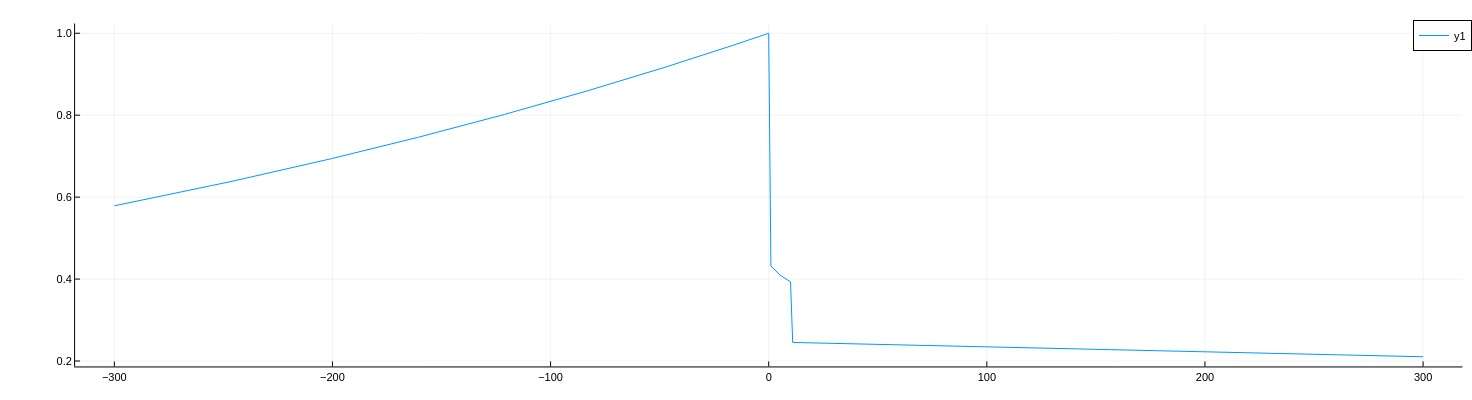

In [31]:
plot(zA,abs.(ModeF))

In [32]:
getind(layer,-12)

1

In [33]:
Mmatr(layer,k0,βS,2)

2×2 Matrix{ComplexF64}:
 0.0463617+0.137672im  -0.147329+0.28867im
 -0.147329+0.28867im   0.0463617+0.137672im

In [34]:
i = 2
layInd  = layerstructure([layer.mat[i-1],layer.mat[i]],[0.0,],"up")
    
    rtCu = rtcoeffs(layInd,k0,[βS,],"down") 
    Relu = rtCu.r.TM[1]
    Telu = rtCu.t.TM[1];

In [35]:
Relu

1.5595546395735784 + 1.5953292326741109im

In [36]:
Telu

2.196918994169537 - 6.523805047789434im

In [37]:
layer.mat[3].n(k₀)

4.1 + 0.051787im

In [38]:
layer.mat[2].n(k₀)

0.5259756784717685 + 2.2209725802903315im

In [39]:
ε₂ = layer.mat[2].ε(k₀)
    ε₁ = layer.mat[1].ε(k₀)

ky1p = kyi(βS,layer.mat[1].k(k₀))
ky2p = kyi(βS,layer.mat[2].k(k₀))
ky3p = kyi(βS,layer.mat[3].k(k₀))



B = 0.5*(1-((ε₂*ky1p)/(ε₁*ky2p))); C = 0.5*(1+((ε₂*ky1p)/(ε₁*ky2p)))

0.28138120116112336 - 0.17538037625642583im

In [40]:
[B , C]

2-element Vector{ComplexF64}:
  0.7186187988388766 + 0.17538037625642583im
 0.28138120116112336 - 0.17538037625642583im

In [41]:
Mmatr(layer,k0,βS,2)*propagate(layer,k₀,βS,2,0)

2×2 Matrix{ComplexF64}:
 0.0463617+0.137672im  -0.147329+0.28867im
 -0.147329+0.28867im   0.0463617+0.137672im

In [42]:
propagate(layer,k₀,βS,2,0)*Mmatr(layer,k0,βS,3)*[1 ,0]

2-element Vector{ComplexF64}:
 0.6233663224505483 + 0.2935496525247303im
 -0.488258919410606 + 0.24644443850187997im

In [43]:
hᵢ = [0,1]

2-element Vector{Int64}:
 0
 1

In [53]:
xGrid = -300:1:300
ind = 1

x₀ = 0

HfArr = zeros(length(xGrid))*im
Tₘ = hᵢ
for i in eachindex(xGrid)
    kyin = kyi(βS,layer.mat[ind].k(k0))
    Tₘl = propagate(layer,k0,βS,ind,xGrid[i]-x₀)*Tₘ
    
    HfArr[i] = sum(Tₘl.*[exp(im*kyin*xGrid[i]),exp(-im*kyin*xGrid[i])])

    if i ≠ length(xGrid)
        if ind ≠ getind(layer,xGrid[i+1])
            ind = getind(layer,xGrid[i+1])
            x₀ = layer.z[ind-1]
            Tₘ =Mmatr(layer,k0,βS,ind)*propagate(layer,k0,βS,ind-1,x₀)*Tₘ
        end
    end
end

HfArr;

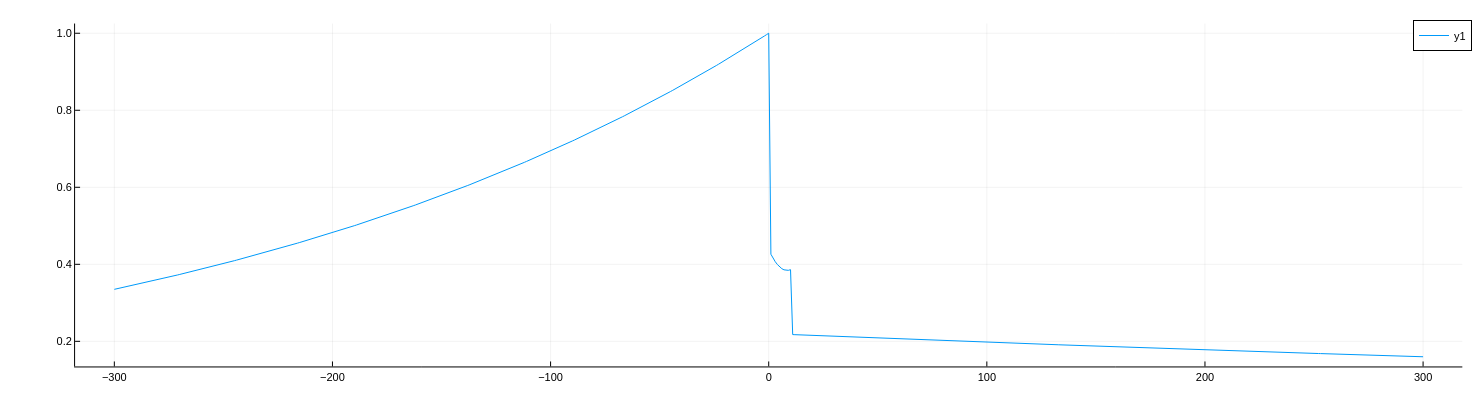

In [54]:
plot(xGrid,abs.(HfArr))

In [46]:
x₀

10.0

In [47]:
 layInd  = layerstructure([layer.mat[ind-1],layer.mat[ind]],[0.0,],"up")
    
    rtCu = rtcoeffs(layInd,k0,[βS,],"up") 
    Relu = rtCu.r.TM[1]
    Telu = rtCu.t.TM[1]
    
    rtCd = rtcoeffs(layInd,k0,[βS,],"down") 
    Reld = rtCd.r.TM[1]
    Teld = rtCd.t.TM[1]

1.3130219485618841 - 0.6183156241782088im

In [48]:
Relu

0.4887142309496958 - 0.6254850753699246im

In [49]:
Reld

-0.4887142309496958 + 0.6254850753699246im

In [50]:
Telu

0.5388945583373118 + 0.7193892237665871im

In [51]:
Teld

1.3130219485618841 - 0.6183156241782088im